<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Andre Gonzalez, Rafael Juarez Badillo

**Fecha:** 15 de febrero del 2024.

**Expediente** : 739922, #####
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Andr3Glez/Proyecto_conjunto3_RAJuarez_ANGonzalez

# Tarea 3: Análisis problema práctico.

# <font color= Red> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [ ]:
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

Código de solución estudiante 1 Andre Gonzalez

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import itertools

In [27]:
data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
data.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [29]:
# Nos quedamos solo con los datos que usaremos
data = data[['date','Energy (kWh)']]
data.head()

,date,Energy (kWh)
0,1990-01-01,498.632
1,1990-01-01,720.409
2,1990-01-01,946.154
3,1990-01-01,987.273
4,1990-01-01,1000.230


In [30]:
# disminuimos los datos usando la media
data = data.set_index('date').resample('M').mean()
data.head()

,Energy (kWh)
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


In [41]:
class Forecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    def acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(10,8))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        
        #Elegimos 6 y 12 por los datos en meses
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')
        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')
        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')
        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')
        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')
        fig.tight_layout()
        
        return res2
        
    def split_trn_tst(self):
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)
        return train_data, test_data

    def eval_forecasts(actual, predicted):
            
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape
    
    def model_forecast(self, history, data, p, d, q, start, end, horizonte=0):
        arima_model = ARIMA(history, order=(p, d, q))
        model = arima_model.fit()
        print(model.summary())

        plt.figure(figsize=(10,10))
        model.plot_diagnostics()
        plt.show()
        model_func = model.predict(start=start, end=end + horizonte, dynamic=False).to_frame()
        ax = data.plot()
        model_func.plot(ax=ax)

        return model_func
    
    def eval_sarimax(self, sarimax_params):
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))
        i = 0
        for par_no_esta, par_esta, trend in sarimax_params[200:210]:
            mod = SARIMAX(
                endog=self.data,
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.evaluated = resultados
        return resultados

In [38]:
LinearForecast = Forecast(data)
LinearForecast.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


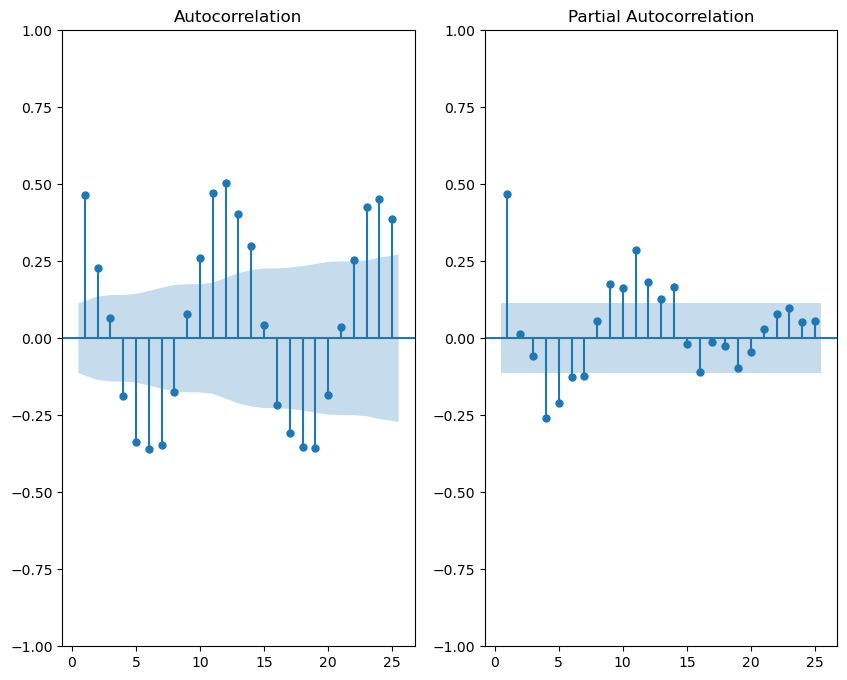

In [39]:
LinearForecast.acf_pacf()

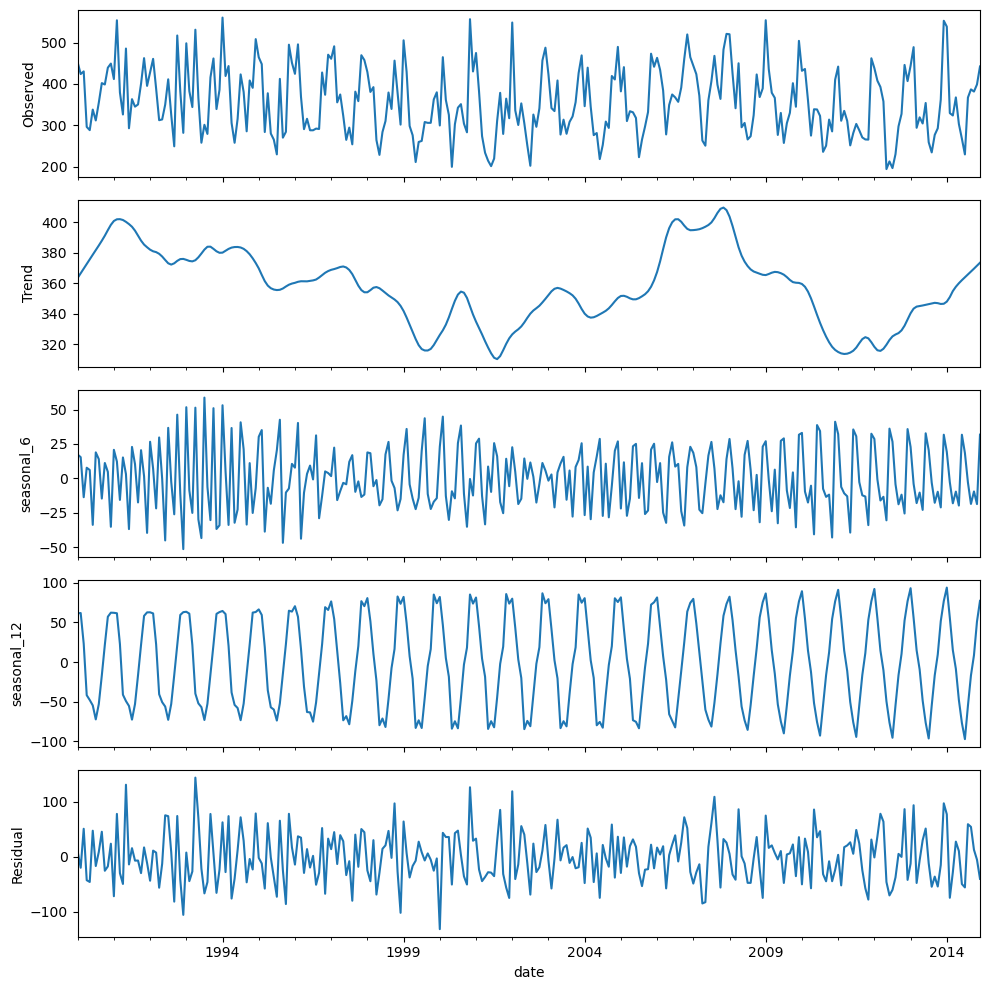

In [42]:
model = LinearForecast.descomposicion()

<Axes: xlabel='date'>

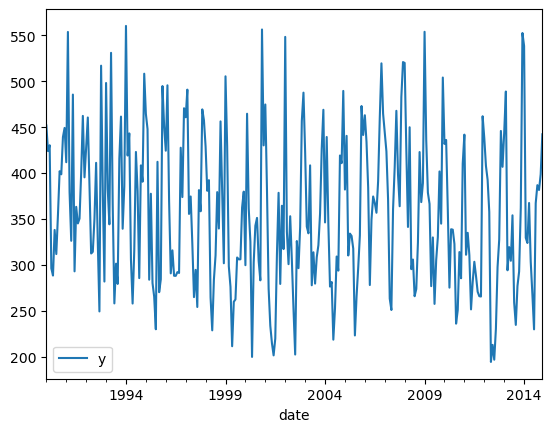

In [43]:
# Grafica con estacionalidad
model.observed.to_frame('y').plot()

<Axes: xlabel='date'>

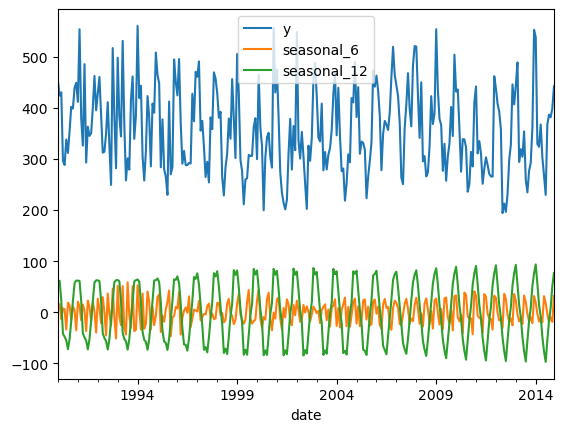

In [44]:
# Datos observados y Datos de estacionalidad
ax = model.observed.to_frame('y')[:400].plot()
model.seasonal[:400].plot(ax=ax)

In [48]:
seasonal_6 = model.seasonal['seasonal_6']
LinearForecast_2 = Forecast(seasonal_6)
LinearForecast_2.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


In [49]:
LinearForecast_2_diff = Forecast(seasonal_6.diff().dropna())
LinearForecast_2_diff.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.483732e+01
p-value                        1.859822e-27
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


In [50]:
seasonal_12 = model.seasonal['seasonal_12']
LinearForecast_3 = Forecast(seasonality_12)
LinearForecast_3.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


In [52]:
LinearForecast_3_diff= Forecast(seasonality_12.diff().dropna())
LinearForecast_3_diff.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -27.731064
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


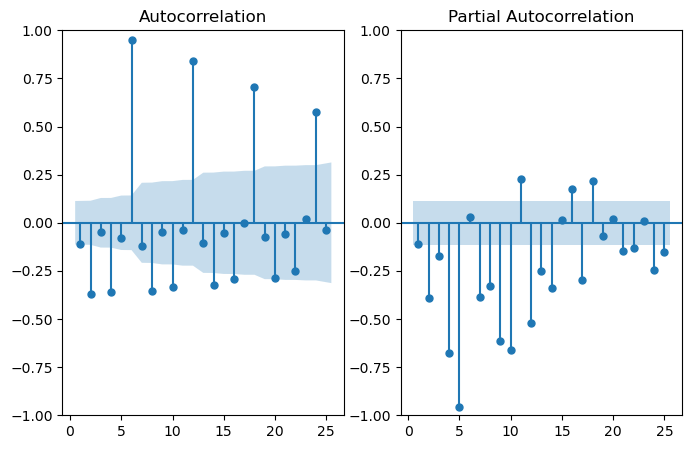

In [16]:
# Sin diferenciar
lf2.plot_acf_pacf()

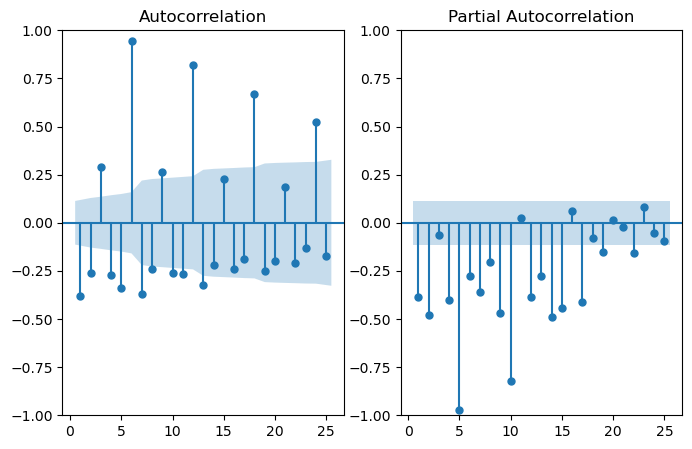

In [17]:
# Diferenciada
lf22.plot_acf_pacf()

<Axes: xlabel='date'>

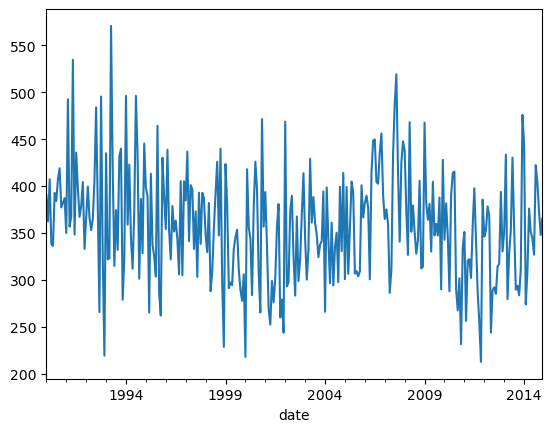

In [53]:
# Serie no estacional
noseasonal = model.observed - model.seasonal['seasonal_12']
noseasonal.plot()

In [54]:
LinearForecast_4 = Forecast(noseasonal)
LinearForecast_4.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -4.543882
p-value                          0.000164
#Lags Used                       5.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64
Stationary


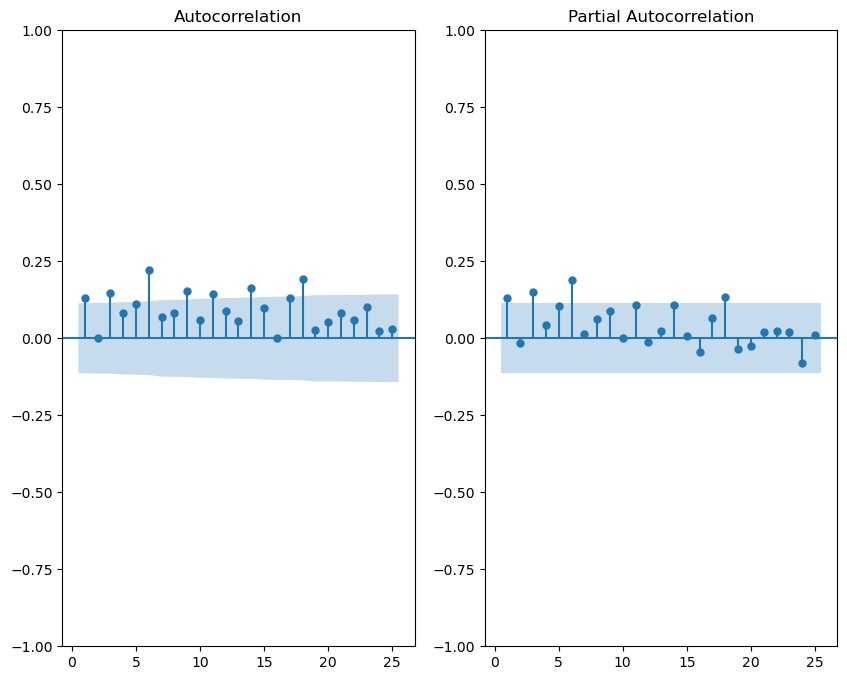

In [57]:
LinearForecast_4.acf_pacf()

In [58]:
# parámetros
p = [0, 1, 2, 3, 4]
d = [1]
q = [0, 1, 2, 3]
P = [0, 1, 2]
D = [0,1]
Q = [0, 1, 2]
t = ['n', 'c', 't', 'ct']

In [59]:
param_noEst = list(itertools.product(p, d, q))
param_est = [(x[0], x[1], x[2], 6) for x in list(itertools.product(P, D, Q))]
params_sarimax = list(itertools.product(param_noEst, param_est, t))
params_sarimax

[((0, 1, 0), (0, 0, 0, 6), 'n'),
 ((0, 1, 0), (0, 0, 0, 6), 'c'),
 ((0, 1, 0), (0, 0, 0, 6), 't'),
 ((0, 1, 0), (0, 0, 0, 6), 'ct'),
 ((0, 1, 0), (0, 0, 1, 6), 'n'),
 ((0, 1, 0), (0, 0, 1, 6), 'c'),
 ((0, 1, 0), (0, 0, 1, 6), 't'),
 ((0, 1, 0), (0, 0, 1, 6), 'ct'),
 ((0, 1, 0), (0, 0, 2, 6), 'n'),
 ((0, 1, 0), (0, 0, 2, 6), 'c'),
 ((0, 1, 0), (0, 0, 2, 6), 't'),
 ((0, 1, 0), (0, 0, 2, 6), 'ct'),
 ((0, 1, 0), (0, 1, 0, 6), 'n'),
 ((0, 1, 0), (0, 1, 0, 6), 'c'),
 ((0, 1, 0), (0, 1, 0, 6), 't'),
 ((0, 1, 0), (0, 1, 0, 6), 'ct'),
 ((0, 1, 0), (0, 1, 1, 6), 'n'),
 ((0, 1, 0), (0, 1, 1, 6), 'c'),
 ((0, 1, 0), (0, 1, 1, 6), 't'),
 ((0, 1, 0), (0, 1, 1, 6), 'ct'),
 ((0, 1, 0), (0, 1, 2, 6), 'n'),
 ((0, 1, 0), (0, 1, 2, 6), 'c'),
 ((0, 1, 0), (0, 1, 2, 6), 't'),
 ((0, 1, 0), (0, 1, 2, 6), 'ct'),
 ((0, 1, 0), (1, 0, 0, 6), 'n'),
 ((0, 1, 0), (1, 0, 0, 6), 'c'),
 ((0, 1, 0), (1, 0, 0, 6), 't'),
 ((0, 1, 0), (1, 0, 0, 6), 'ct'),
 ((0, 1, 0), (1, 0, 1, 6), 'n'),
 ((0, 1, 0), (1, 0, 1, 6), 'c'),
 ((

In [60]:
train, test = lf.split_dataset()
data['ln_y'] = np.log(train['Energy (kWh)'])

In [62]:
LinearForecast = Forecast(train)
LinearForecast.eval_sarimax(params_sarimax)

C:\Users\andre\anaconda3\envs\modelos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\anaconda3\envs\modelos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\anaconda3\envs\modelos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\anaconda3\envs\modelos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\anaconda3\envs\modelos\Lib\site-p

,params,AIC,BIC,LLF
0,"((0, 1, 2), (2, 0, 2, 6), 'n')",2665.819839,2690.155083,-1325.909919
1,"((0, 1, 2), (2, 0, 2, 6), 'c')",2675.734596,2703.546305,-1329.867298
2,"((0, 1, 2), (2, 0, 2, 6), 't')",2706.621609,2734.433317,-1345.310804
3,"((0, 1, 2), (2, 0, 2, 6), 'ct')",2704.507466,2735.795638,-1343.253733
4,"((0, 1, 2), (2, 1, 0, 6), 'n')",2710.046488,2727.30168,-1350.023244
5,"((0, 1, 2), (2, 1, 0, 6), 'c')",2711.828058,2732.534289,-1349.914029
6,"((0, 1, 2), (2, 1, 0, 6), 't')",2711.833306,2732.539537,-1349.916653
7,"((0, 1, 2), (2, 1, 0, 6), 'ct')",2762.013653,2786.170922,-1374.006826
8,"((0, 1, 2), (2, 1, 1, 6), 'n')",2668.199522,2688.905753,-1328.099761
9,"((0, 1, 2), (2, 1, 1, 6), 'c')",2667.193628,2691.350897,-1326.596814


El mejor modelo en base a la tabla es el primero con los parametros ((0, 1, 2), (2, 0, 2, 6), 'n'